# This script implements a simple baseline-CNN model for the Music Genre Classification task.
It can be used as a Jupyter- or Colab-Notebook.



# Colab-Specific

## Installs

In [0]:
!pip install rarfile
!pip install tensorflow==2.0.0-rc0
!pip install scikit-image==0.15.0

## Mount GDrive to Colab session

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##  Set path to dataset stored in GDrive
Distinguish between train- and test data. Make sure dataset is added to '***My Drive***'! 

In [0]:
data_storage_path = '/content/drive/My Drive/ML/ML_experiments'
path_train_data_set = '/content/drive/My Drive/ML/dataset_transformed/spectrograms512_train'
path_test_data_set = '/content/drive/My Drive/ML/dataset_transformed/spectrograms512_test'

In [0]:
# Imports mainly for debugging
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt

# Imports

In [0]:
# System/zip-/rar-handling imports
import os, sys
import zipfile
import rarfile # Needs 'unrar'. On Ubuntu: install via "sudo apt-get install unrar"; pip didn't work here.

# Imports tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib

# Imports image handling
import cv2
import numpy as np
import skimage

# For generating training and test data
import random

# Save training progress
import csv
from datetime import datetime
from shutil import copyfile  # Making copy of this file instance (including param settings used)


# IF DEALING WITH ZIP FILE! (Outdated)

## Get sorted list of training file names:

In [0]:
# Get access to zip-archive
# Local:
#archive = zipfile.ZipFile('../data/spectrograms.zip', 'r')
#imgdata = archive.read('spectrograms/spectrogram_0000.png')

# Colab:
archive = zipfile.ZipFile('/content/drive/My Drive/ML/data/spectrograms.zip', 'r')
imgdata = archive.read('spectrograms/spectrogram_0000.png')

files = sorted([f for f in archive.namelist()[1:] if f.startswith('spectrograms/') and f.endswith('.png')])

print(files)

FileNotFoundError: ignored

## Read in both training and testing data from combined zip archive:

In [0]:
data_set = []
# Data storage
combined_data = np.empty([1, 128, 128])

# Read in images & store processed instances
for f_name in files:
    # Get image data from zip file
    zip_img_data = archive.read(f_name)
    image = cv2.imdecode(np.frombuffer(zip_img_data, dtype=np.uint8), 1)
    
    # Normalize image's colors to range [0, 1]
    image = image / 255.0

    # Grayscale image
    gray_image = skimage.color.rgb2gray(image)

    # Store grayscaled image
    combined_data = np.append(combined_data, [gray_image], axis=0)
    
# Remove initial, empty datapoint
combined_data = combined_data[1:, :, :]

print('Done reading in... Shape of data array:')
print(combined_data.shape)
print('Done.')

## Read in labels:

In [0]:
labels_path = '../data/labels.txt'

combined_labels = np.empty([1])

with open(labels_path, 'r') as file:
    for line in file:
        combined_labels = np.append(combined_labels, [int(line)])

# Remove initial, empty datapoint
combined_labels = combined_labels[1:] 
print(combined_labels)

## Divide data into train and test data:

------------------------------------------------------
Training data will be contained in:    training_data
Tetsing  data will be contained in:    testing_data

Training labels will be contained in:  training_labels
Tetsing  labels will be contained in:  testing_labels

In [0]:
# Get set of test-indices which indicates the training data points that have to be reserved for training
percentage_test_data = 0.2
population = range(len(combined_labels))
nr_samples = int(percentage_test_data * len(combined_labels))

test_indices = random.sample(population, nr_samples)
test_indices = sorted(test_indices)

print('Nr. test indices: ' + str(len(test_indices)))
print('Test indices: ' + str(test_indices))


# Split data into training- and test data, respectively - Preparation: Create empty arrays in which to later insert data
test_len = len(test_indices)
train_len = len(combined_labels)-len(test_indices)
training_data, training_labels = np.empty([train_len, 128, 128]), np.empty([train_len])
testing_data, testing_labels = np.empty([test_len, 128, 128]), np.empty([test_len])

test_idx_list_idx = 0
i = 0

# Iterate through all data and assign each data point either to training data or testing data
for data_idx in range(len(combined_labels)):

    if test_idx_list_idx < nr_samples and data_idx == test_indices[test_idx_list_idx]:
        testing_data[test_idx_list_idx, :, :] = combined_data[data_idx, :, :]
        testing_labels[test_idx_list_idx] = combined_labels[data_idx]
        test_idx_list_idx += 1
        
    else:
        
        training_data[i, :, :] = combined_data[data_idx, :, :]
        training_labels[i] = combined_labels[data_idx]
        i += 1
        

training_data = training_data.reshape([len(training_labels), 128, 128, 1])

testing_data = testing_data.reshape([len(testing_labels), 128, 128, 1])
        
print('Final:')
print(training_data.shape)
print(training_labels.shape)
print(testing_data.shape)
print(testing_labels.shape)


# IF DEALING WITH RAR FILE *AND* RAM IS LARGE ENOUGH FOR ENTIRE DATA SET! (Outdated)

## Read in data & create training- and testing data sets (Outdated)

In [0]:
data_path = '/content/drive/My Drive/ML/data/'
archive_name = 'spectograms_512.rar'

if rarfile.is_rarfile(data_path + archive_name):
    print('Is rar...')
    # Read in file names per data (train vs test) set
    class_labels = {'blues': 0,
                    'classical': 1,
                    'country': 2,
                    'disco': 3,
                    'hiphop': 4,
                    'jazz': 5,
                    'metal': 6,
                    'pop': 7,
                    'reggae': 8,
                    'rock': 9
                    }

    rf = rarfile.RarFile(data_path + archive_name)

    train_files, test_files = [], []
    train_labels, test_labels = [], []

    for f in rf.infolist():
        f_name = f.filename
        if f_name.startswith('spectrograms') and f_name.endswith('.png'):
            p_parts = f_name.split('/')
            label = class_labels[p_parts[1]]
            if 'train' in f_name:
                train_files.append(f_name)
                train_labels.append(label)
            elif 'test' in f.filename:
                test_files.append(f_name)
                test_labels.append(label)

    num_training_data = len(train_labels)
    num_testing_data = len(test_labels)
    print('Len train data: ' + str(num_training_data))
    print('Len test data: ' + str(num_testing_data))

    # Read in data
else:
    print('No rar')
    raise Exception('No rar!')

##### TRAINING DATA AND LABELS #####

# Get TRAIN image data from rar file
dimension = np.array((cv2.imdecode(np.frombuffer(rf.read(train_files[0]), dtype=np.uint8), 1))).shape
print('Dimensions: ' + str(dimension))
print('Training set size: ' + str(num_training_data))

training_data = np.empty([num_training_data, dimension[0], dimension[1]])
print('Allocated.')

for i, file in enumerate(train_files):

    if i % 100 == 0:
        print('Train: ' + str(i))

    try:
      rar_img_data = rf.read(file)
      image = cv2.imdecode(np.frombuffer(rar_img_data, dtype=np.uint8), 1)

      # Normalize image's colors to range [0, 1]
      image = image / 255.0

      # Grayscale image
      gray_image = skimage.color.rgb2gray(image)

      # Store grayscaled image
      #training_data = np.append(training_data, [gray_image], axis=0)
      training_data[i,:,:] = gray_image
    except Exception as e:
      print('Error: ' + str(file))
      print(e)

print('Done reading in... Shape of data array:')
print(training_data.shape)
print('Done.')

# Get TRAIN labels
training_labels = np.array(train_labels)
print(train_labels)


##### TESTING DATA AND LABELS #####

# Get TEST image data from rar file
testing_data = np.empty([num_testing_data, dimension[0], dimension[1]])  # TODO: change procedure here as well to pre-allocating space and NOT removing first element

for i, file in enumerate(test_files):
    
    if i % 100 == 0:
        print('Train: ' + str(i))
    try:
      rar_img_data = rf.read(file)
      image = cv2.imdecode(np.frombuffer(rar_img_data, dtype=np.uint8), 1)

      # Normalize image's colors to range [0, 1]
      image = image / 255.0

      # Grayscale image
      gray_image = skimage.color.rgb2gray(image)

      # Store grayscaled image
      testing_data[i,:,:] = gray_image
    except Exception as e:
      print('Error: ' + str(file))
      print(e)

print('Done reading in... Shape of data array:')
print(testing_data.shape)
print('Done.')

# Get TEST labels
testing_labels = np.array(test_labels)
print(testing_labels)
rf = None # Clear ram space

# Set up folder for data gathering during training process

In [0]:
# Set up folder for data gathering during training process
now = datetime.now()
TIME_STAMP = now.strftime("_%Y_%d_%m__%H_%M_%S__%f")
MODEL_ID = 'Model_' + TIME_STAMP + '/'
training_path = data_storage_path + '/Trained_Models/CNN_Models/' #'../Trained_Models/CNN_Models/'
path = training_path + MODEL_ID + '/'

if not os.path.exists(path):
    os.makedirs(path)
    print('Created dir: ' + path)
else:
    path = None
    raise Exception('PATH EXISTS!')

# Set up the CNN architecture & helpers

## Define Model Architecture

In [15]:
#%%writefile $path/model_settings.text 
# Line above: Save model settings to file for reproducability - Run once with command above and once without. 
# First, it saves cell's content, but doesn't run the cell, afterwards, it's running the cell

# Reset tf sessions
tf.keras.backend.clear_session()  # Destroys the current TF graph and creates a new one.

dimensions = 512 # Image-Dimension: 512x512x1 (BW-image)
classes = 10

# Set up model architecture in terms of its layers
model = models.Sequential()

# Set layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions, dimensions, 1), # 32 batch size
                                                       kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dropout(0.05))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.05))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

model.add(layers.Dropout(0.1))

model.add(layers.Dense(classes, activation='softmax'))

# Note on regularizer(s), copied from https://www.tensorflow.org/tutorials/keras/overfit_and_underfit:
# l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2
# to the total loss of the network.

# Print summary
model.summary()

# Compile model & make some design choices
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001,
                                           beta_1=0.9,
                                           beta_2=0.999,
                                           epsilon=1e-07,
                                           amsgrad=False,
                                           name='Adam'
                                           ),
              loss='sparse_categorical_crossentropy',  # Capable of working with regularization
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
dropout (Dropout)            (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0

## Define Callbacks

In [0]:
# Definition of callbacks adjusted from https://www.tensorflow.org/guide/keras/train_and_evaluate

early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',    # Stop training when `val_loss` is no longer improving
        min_delta=0,               # "no longer improving" being defined as "no better than 0|5e-1 less"
        patience=2,                # "no longer improving" being further defined as "for at least 2 epochs"
        verbose=0)                 # Quantity of printed output

model_saving_callback = ModelCheckpoint(
        filepath=path+'cnn_model.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        # mode: one of {auto, min, max}. If `save_best_only=True`, the decision to
        # overwrite the current save file is made based on either the maximization
        # or the minimization of the monitored quantity. For `val_acc`, this
        # should be `max`, for `val_loss` this should be `min`, etc. In `auto`
        # mode, the direction is automatically inferred from the name of the
        # monitored quantity.
        verbose=0)

# Join list of required callbacks
callbacks = [model_saving_callback] # Outtake: early_stopping_callback

## Define Data Generator

Pre-Processing

In [0]:
def preprocessing_function(x):
    """
    Could be used for rotating image in RNN, for example.
    """
    #assert x.shape == (512, 512, 1)
    return x



## Training data generator

In [18]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                     #preprocessing_function=preprocessing_function
                                                     )

BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = 25 #np.ceil(image_count/BATCH_SIZE)
data_dir = path_train_data_set
data_dir = pathlib.Path(data_dir)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])


train_data_gen = train_image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     color_mode='grayscale',
                                                     class_mode='sparse', # Class represented by 1 integer (instead of categorical==1-hot-encoding)
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 9600 images belonging to 10 classes.


## Test|Evaluation data generator

In [19]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                     #preprocessing_function=preprocessing_function
                                                     )

BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = 25 #np.ceil(image_count/BATCH_SIZE)
data_dir = path_test_data_set
data_dir = pathlib.Path(data_dir)


CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])


test_data_gen = test_image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     color_mode='grayscale',
                                                     class_mode='sparse',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 600 images belonging to 10 classes.


# Test data imports  (train) generator

### Helper function

In [0]:
def show_batch(image_batch, label_batch):
  print('Batch dimensions: ' + str(image_batch.shape))
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      image = image_batch[n]
      # If grayscale, repeat 1 channel 3 times for visualization
      if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)
      plt.imshow(image)
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


### Visualize generated example batch and labels


Batch dimensions: (32, 512, 512, 1)


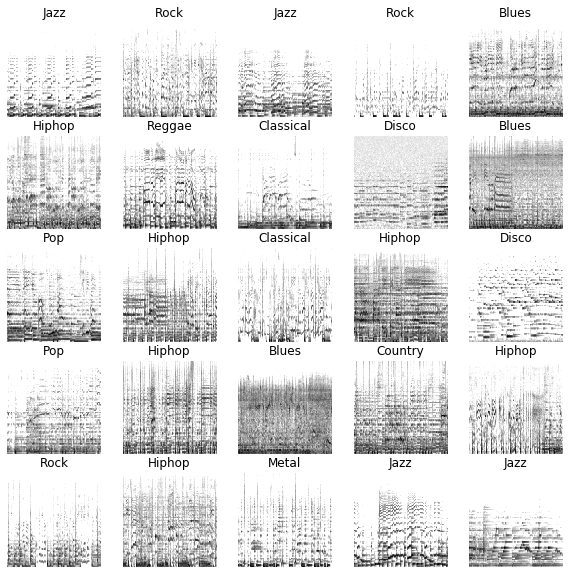

In [69]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Perform training

'accuracy' == accuracy achieved during training on training data

'val_accuracy' == accuracy achieved on Test/Evaluation data

In [0]:
# Set number of desired epochs (mind the early-stopping!)
epochs = 10

# Perform x epochs of training
#history = model.fit(training_data, training_labels,
#                    epochs=epochs,
#                    validation_data=(testing_data, testing_labels),
#                    callbacks=callbacks, verbose=1)


history = model.fit_generator(
                              train_data_gen,
                              steps_per_epoch=25, 
                              epochs=epochs,
                              validation_data=test_data_gen,
                              validation_steps=18,
                              callbacks=callbacks, 
                              max_queue_size=10,
                              verbose=1
          )



# Save the entire model as a final model to a HDF5 file.
name = 'final_model'
model.save(path+name+'.h5')

# Record training progress
with open(path+'training_progress.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy", "sparse_categorical_crossentropy"])
    for line in range(len(history.history['loss'])): 
        epoch = str(line+1)
        writer.writerow([epoch,
                         history.history["loss"][line], 
                         history.history["accuracy"][line], 
                         history.history["val_loss"][line], 
                         history.history["val_accuracy"][line],
                         history.history["sparse_categorical_crossentropy"][line]
                         ])
    file.close()

print('Done.')

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
25/25 [==============================] - 750s 30s/step - loss: 18.7653 - accuracy: 0.1088 - sparse_categorical_crossentropy: 13.8133 - val_loss: 16.1275 - val_accuracy: 0.1007 - val_sparse_categorical_crossentropy: 14.2429
Epoch 2/10
25/25 [==============================] - 261s 10s/step - loss: 8.3435 - accuracy: 0.0775 - sparse_categorical_crossentropy: 6.3799 - val_loss: 3.3713 - val_accuracy: 0.1007 - val_sparse_categorical_crossentropy: 2.3077
Epoch 3/10
25/25 [==============================] - 365s 15s/step - loss: 2.8104 - accuracy: 0.1250 - sparse_categorical_crossentropy: 2.3046 - val_loss: 2.5425 - val_accuracy: 0.1007 - val_sparse_categorical_crossentropy: 2.3356
Epoch 4/10
11/25 [============>.................] - ETA: 3:01 - loss: 2.4913 - accuracy: 0.0909 - sparse_categorical_crossentropy: 2.3128